<a href="https://colab.research.google.com/github/lorenzrossi/MachineLearning/blob/master/Model_cnn_five_block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
from os import listdir
import pandas as pd
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# Image preprocessing
import pathlib
import PIL
import PIL.Image
import cv2

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Cross Validation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, zero_one_loss

tfk = tf.keras
tf.keras.backend.set_floatx("float64")
%load_ext tensorboard


from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/CatsDogs'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Mounted at /content/drive


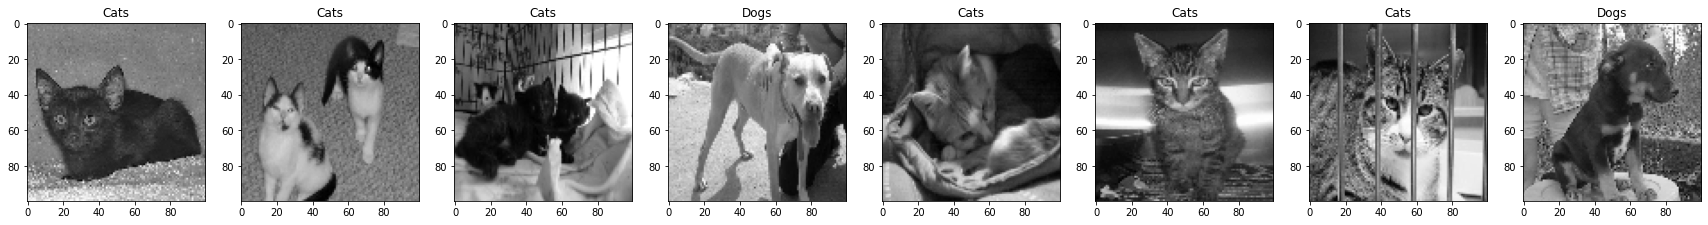

In [5]:
X = pickle.load(open('/content/drive/MyDrive/CatsDogs/Pickles/X.pickle','rb'))
y = pickle.load(open('/content/drive/MyDrive/CatsDogs/Pickles/y.pickle','rb'))

pets_classes = ['Cats','Dogs']

images_to_plot = 8

gray_channel = 0

f, ax = plt.subplots(1, images_to_plot)
f.set_size_inches(30, 20)

for i in range(images_to_plot):
  gray_image = X[i][:, :, gray_channel]
  ax[i].imshow(gray_image, cmap = "gray")
  numeric_label = y[i]
  ax[i].set_title(pets_classes[numeric_label])

In [6]:
number_of_classes = len(pets_classes)

In [7]:
x_size, img_dim = X.shape[0], X.shape[1]

# rescale in [0,1]
X = tf.cast(X, tf.float32) / 255.0

In [8]:
depth = 1
y = tf.reshape(tf.one_hot(y, depth), shape = [x_size, depth])

In [9]:
# Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [10]:
# Hyperparameters
epoch = 50 # n of epochs
batch = 64 # batch size

# Defining the loss
loss = keras.losses.BinaryCrossentropy()

# Defining the optimizer(s)
op_1 = Adam()
op_2 = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/50)
op_3 = RMSprop(learning_rate=1e-4)

In [11]:
# Defining plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    # Loss plots
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    # Accuracy plots
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    plt.show()

# Models
Model 1 is the base architecture

Model 2 adds dropout layers

Model 3 adds batch normalization layers 

In [9]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      288       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18432     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36864     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                    

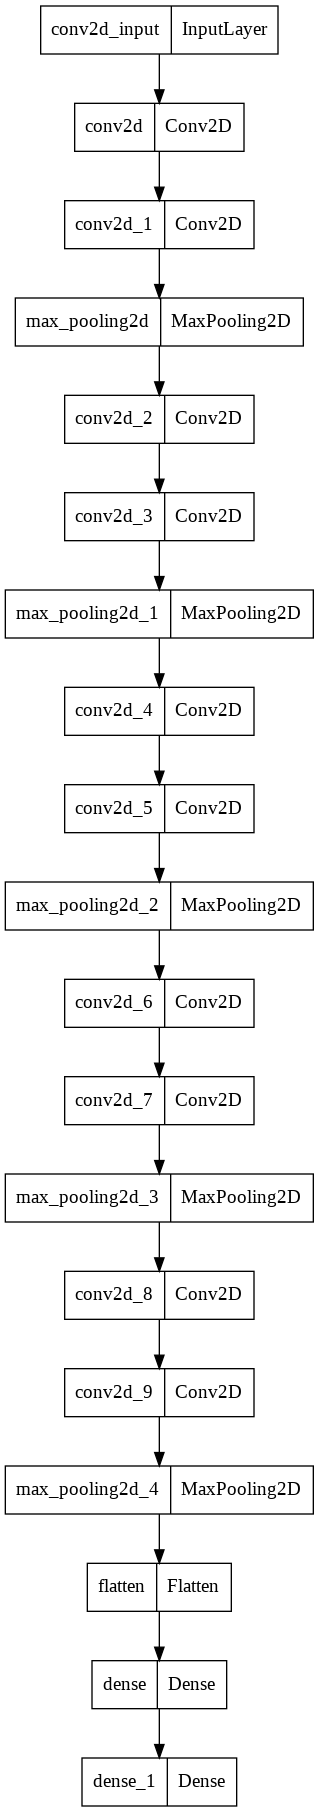

In [10]:
keras.utils.plot_model(model1, 'model1.png')

In [11]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        18432     
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        36864     
                                                      

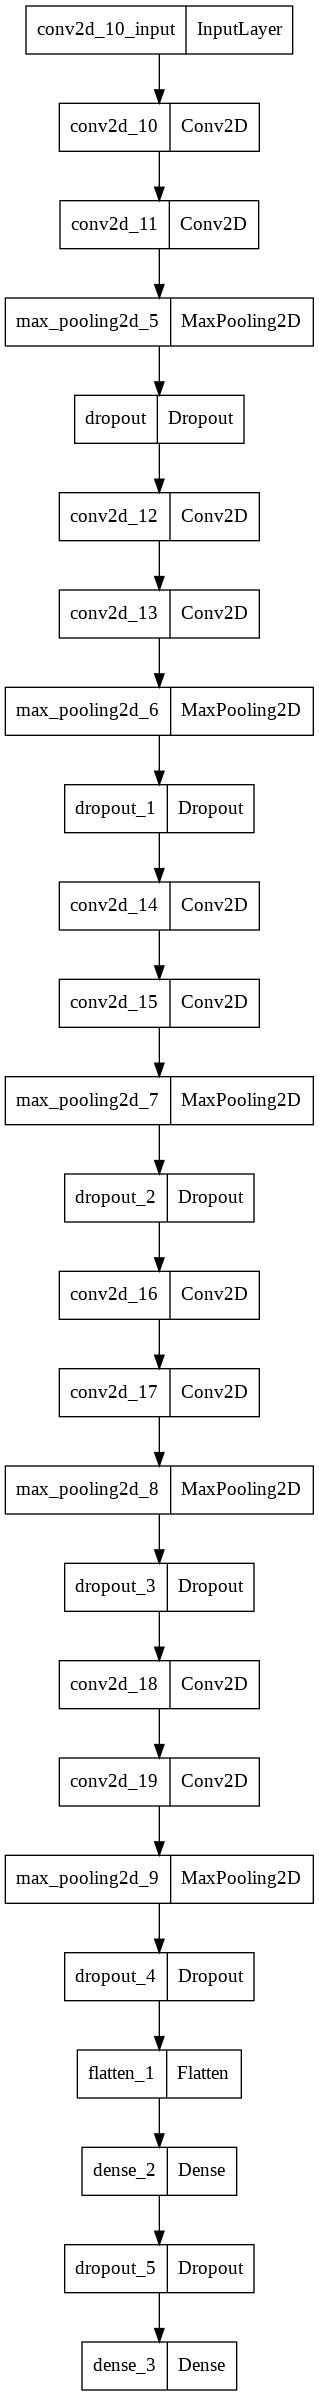

In [12]:
keras.utils.plot_model(model2, 'model2.png')

In [12]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      288       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                        

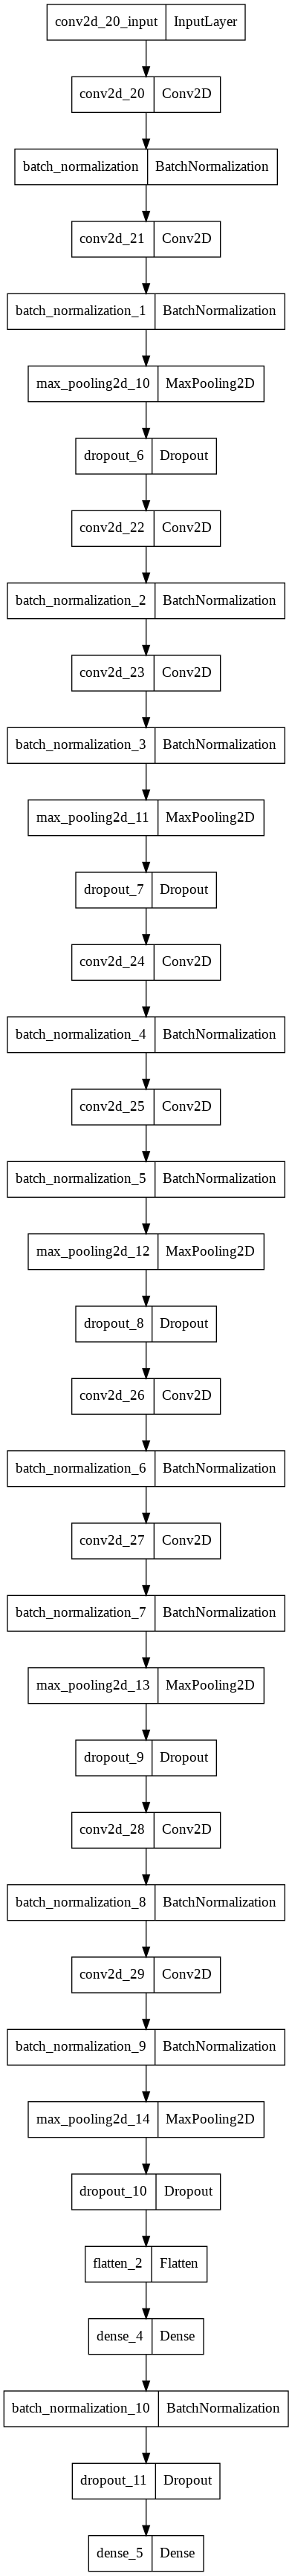

In [14]:
keras.utils.plot_model(model3, 'model3.png')

Epoch 1/50
313/313 [==============================] - 21s 54ms/step - loss: 0.6934 - binary_accuracy: 0.4955 - val_loss: 0.6932 - val_binary_accuracy: 0.4898
Epoch 2/50
313/313 [==============================] - 16s 52ms/step - loss: 0.6935 - binary_accuracy: 0.5006 - val_loss: 0.6932 - val_binary_accuracy: 0.4898
Epoch 3/50
313/313 [==============================] - 16s 52ms/step - loss: 0.6932 - binary_accuracy: 0.4983 - val_loss: 0.6931 - val_binary_accuracy: 0.4898
Epoch 4/50
313/313 [==============================] - 16s 52ms/step - loss: 0.6937 - binary_accuracy: 0.4989 - val_loss: 0.6931 - val_binary_accuracy: 0.5102
Epoch 5/50
313/313 [==============================] - 16s 52ms/step - loss: 0.6933 - binary_accuracy: 0.5024 - val_loss: 0.6932 - val_binary_accuracy: 0.4898
Epoch 6/50
313/313 [==============================] - 16s 52ms/step - loss: 0.6932 - binary_accuracy: 0.5021 - val_loss: 0.6932 - val_binary_accuracy: 0.4898
Epoch 7/50
313/313 [==============================] 

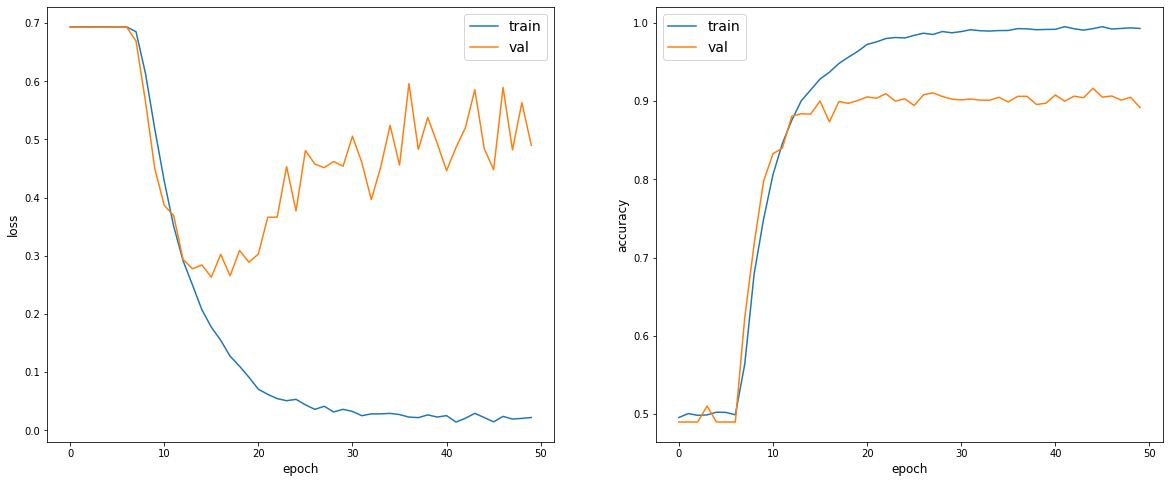

157/157 [==============================] - 2s 12ms/step - loss: 0.4899 - binary_accuracy: 0.8917
test loss, test acc: [0.48992823203566044, 0.8917133706965572]


In [15]:
# TRAINING MODEL 1

# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

Epoch 1/50
313/313 [==============================] - 18s 54ms/step - loss: 0.6995 - binary_accuracy: 0.4961 - val_loss: 0.6931 - val_binary_accuracy: 0.5102
Epoch 2/50
313/313 [==============================] - 17s 53ms/step - loss: 0.6933 - binary_accuracy: 0.5055 - val_loss: 0.6882 - val_binary_accuracy: 0.5282
Epoch 3/50
313/313 [==============================] - 17s 53ms/step - loss: 0.6882 - binary_accuracy: 0.5377 - val_loss: 0.6662 - val_binary_accuracy: 0.6213
Epoch 4/50
313/313 [==============================] - 17s 53ms/step - loss: 0.6639 - binary_accuracy: 0.6110 - val_loss: 0.6458 - val_binary_accuracy: 0.6477
Epoch 5/50
313/313 [==============================] - 17s 53ms/step - loss: 0.6375 - binary_accuracy: 0.6446 - val_loss: 0.6310 - val_binary_accuracy: 0.6579
Epoch 6/50
313/313 [==============================] - 17s 53ms/step - loss: 0.6137 - binary_accuracy: 0.6645 - val_loss: 0.5915 - val_binary_accuracy: 0.6906
Epoch 7/50
313/313 [==============================] 

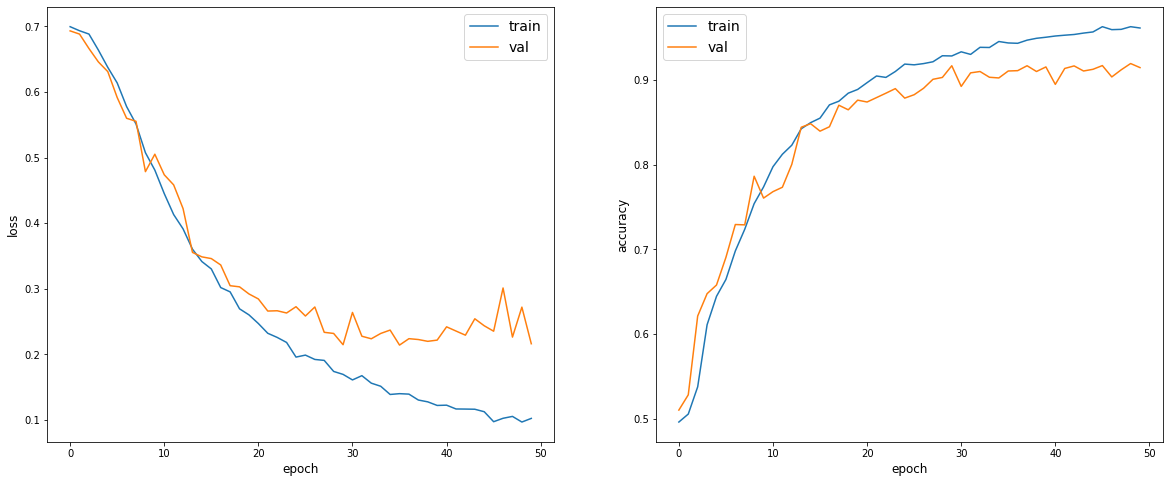

157/157 [==============================] - 2s 12ms/step - loss: 0.2160 - binary_accuracy: 0.9147
test loss, test acc: [0.21603926887849517, 0.9147317854283427]


In [16]:
# TRAINING MODEL 2

# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

Epoch 1/50
313/313 [==============================] - 42s 86ms/step - loss: 0.7508 - binary_accuracy: 0.6192 - val_loss: 2.4449 - val_binary_accuracy: 0.5030
Epoch 2/50
313/313 [==============================] - 26s 84ms/step - loss: 0.5208 - binary_accuracy: 0.7483 - val_loss: 0.5088 - val_binary_accuracy: 0.7420
Epoch 3/50
313/313 [==============================] - 26s 84ms/step - loss: 0.3958 - binary_accuracy: 0.8217 - val_loss: 0.3952 - val_binary_accuracy: 0.8219
Epoch 4/50
313/313 [==============================] - 26s 84ms/step - loss: 0.3143 - binary_accuracy: 0.8657 - val_loss: 0.2813 - val_binary_accuracy: 0.8779
Epoch 5/50
313/313 [==============================] - 26s 84ms/step - loss: 0.2566 - binary_accuracy: 0.8899 - val_loss: 0.4023 - val_binary_accuracy: 0.8122
Epoch 6/50
313/313 [==============================] - 26s 84ms/step - loss: 0.2287 - binary_accuracy: 0.9034 - val_loss: 0.2460 - val_binary_accuracy: 0.8927
Epoch 7/50
313/313 [==============================] 

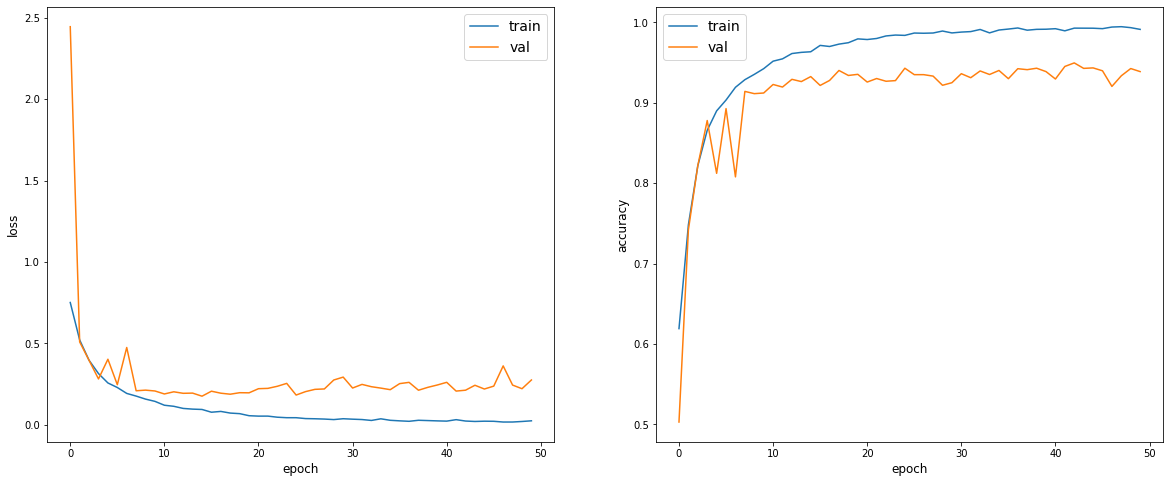

157/157 [==============================] - 2s 14ms/step - loss: 0.2749 - binary_accuracy: 0.9388
test loss, test acc: [0.2749085684306098, 0.9387510008006406]


In [13]:
# TRAINING MODEL 3 with Adam

# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_op1 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_op1)

Epoch 1/50
625/625 [==============================] - 22s 34ms/step - loss: 0.6983 - binary_accuracy: 0.5043 - val_loss: 0.6931 - val_binary_accuracy: 0.5030
Epoch 2/50
625/625 [==============================] - 21s 33ms/step - loss: 0.6932 - binary_accuracy: 0.5005 - val_loss: 0.6931 - val_binary_accuracy: 0.5030
Epoch 3/50
625/625 [==============================] - 21s 33ms/step - loss: 0.6932 - binary_accuracy: 0.4962 - val_loss: 0.6931 - val_binary_accuracy: 0.5030
Epoch 4/50
625/625 [==============================] - 21s 33ms/step - loss: 0.6933 - binary_accuracy: 0.5051 - val_loss: 0.6932 - val_binary_accuracy: 0.4976
Epoch 5/50
625/625 [==============================] - 21s 33ms/step - loss: 0.6922 - binary_accuracy: 0.5177 - val_loss: 0.6825 - val_binary_accuracy: 0.5524
Epoch 6/50
625/625 [==============================] - 21s 33ms/step - loss: 0.6743 - binary_accuracy: 0.5885 - val_loss: 0.6627 - val_binary_accuracy: 0.6255
Epoch 7/50
625/625 [==============================] 

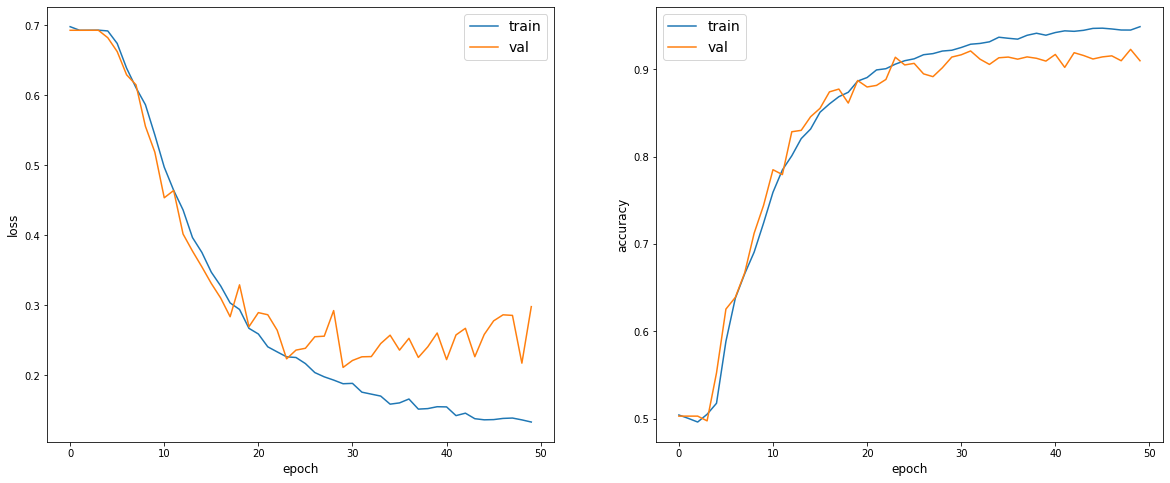

157/157 [==============================] - 2s 13ms/step - loss: 0.2982 - binary_accuracy: 0.9097
test loss, test acc for batch 32: [0.2981878405774282, 0.9097277822257807]
Epoch 1/50
157/157 [==============================] - 17s 100ms/step - loss: 0.7012 - binary_accuracy: 0.4970 - val_loss: 0.6931 - val_binary_accuracy: 0.5030
Epoch 2/50
157/157 [==============================] - 15s 99ms/step - loss: 0.6932 - binary_accuracy: 0.4943 - val_loss: 0.6931 - val_binary_accuracy: 0.4970
Epoch 3/50
157/157 [==============================] - 15s 99ms/step - loss: 0.6929 - binary_accuracy: 0.5082 - val_loss: 0.6894 - val_binary_accuracy: 0.5488
Epoch 4/50
157/157 [==============================] - 15s 99ms/step - loss: 0.6817 - binary_accuracy: 0.5538 - val_loss: 0.6694 - val_binary_accuracy: 0.6117
Epoch 5/50
157/157 [==============================] - 15s 99ms/step - loss: 0.6496 - binary_accuracy: 0.6275 - val_loss: 0.6597 - val_binary_accuracy: 0.5999
Epoch 6/50
157/157 [=================

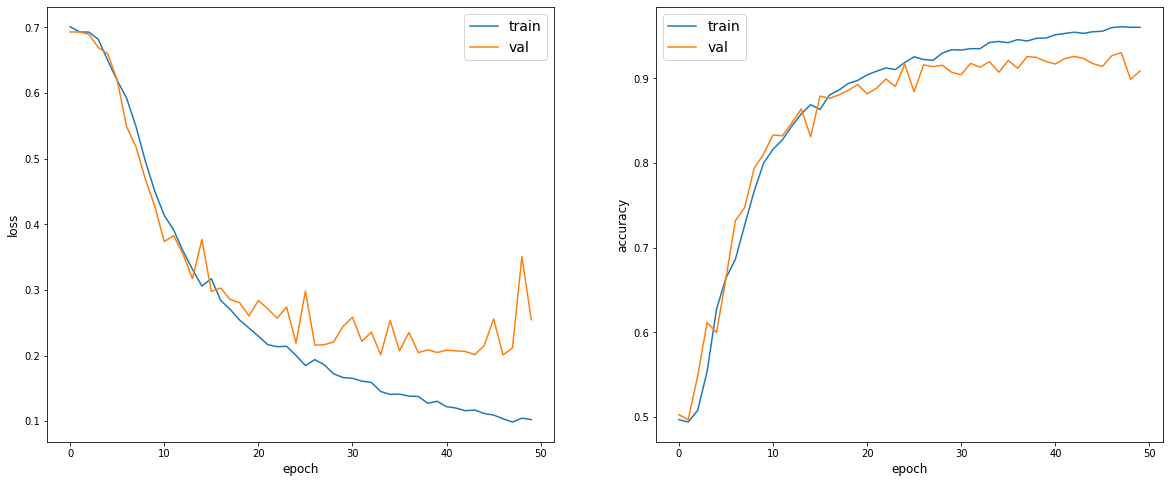

157/157 [==============================] - 2s 13ms/step - loss: 0.2547 - binary_accuracy: 0.9085
test loss, test acc for batch 128: [0.25468657223805247, 0.9085268214571657]
Epoch 1/50
79/79 [==============================] - 16s 187ms/step - loss: 0.7080 - binary_accuracy: 0.5178 - val_loss: 0.6810 - val_binary_accuracy: 0.5616
Epoch 2/50
79/79 [==============================] - 15s 184ms/step - loss: 0.6699 - binary_accuracy: 0.5930 - val_loss: 0.6678 - val_binary_accuracy: 0.6081
Epoch 3/50
79/79 [==============================] - 15s 184ms/step - loss: 0.6576 - binary_accuracy: 0.6139 - val_loss: 0.6585 - val_binary_accuracy: 0.6355
Epoch 4/50
79/79 [==============================] - 15s 184ms/step - loss: 0.6430 - binary_accuracy: 0.6356 - val_loss: 0.6624 - val_binary_accuracy: 0.5861
Epoch 5/50
79/79 [==============================] - 15s 185ms/step - loss: 0.6388 - binary_accuracy: 0.6351 - val_loss: 0.6302 - val_binary_accuracy: 0.6575
Epoch 6/50
79/79 [=======================

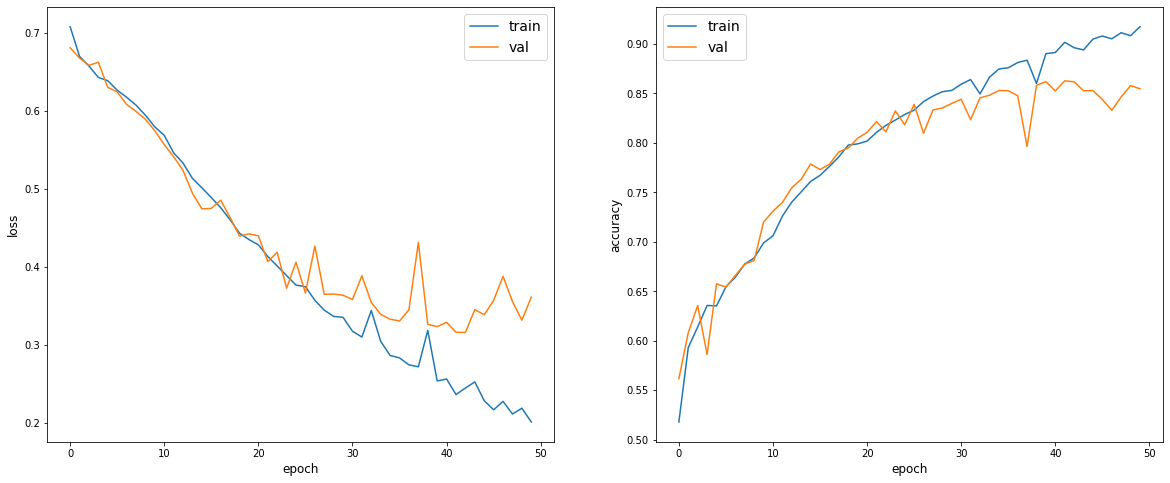

157/157 [==============================] - 2s 13ms/step - loss: 0.3615 - binary_accuracy: 0.8547
test loss, test acc for batch 256: [0.3615008388530058, 0.8546837469975981]


In [15]:
# Model 2 and model 3 are the best, so I run different tries with different batche sizes in order to find the best parameter


batches = [32, 128, 256]

for batch in batches:
  model2 = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
      tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])
  # compiling the model
  model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

  history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

  performance_plot(history)

  result_2 = model2.evaluate(X_test, y_test)
  print(f"test loss, test acc for batch {batch}:", result_2)

Epoch 1/50
625/625 [==============================] - 34s 49ms/step - loss: 0.7099 - binary_accuracy: 0.5917 - val_loss: 1.0177 - val_binary_accuracy: 0.5442
Epoch 2/50
625/625 [==============================] - 30s 48ms/step - loss: 0.5888 - binary_accuracy: 0.6869 - val_loss: 0.6502 - val_binary_accuracy: 0.6793
Epoch 3/50
625/625 [==============================] - 30s 48ms/step - loss: 0.5278 - binary_accuracy: 0.7356 - val_loss: 0.5000 - val_binary_accuracy: 0.7590
Epoch 4/50
625/625 [==============================] - 30s 48ms/step - loss: 0.4574 - binary_accuracy: 0.7837 - val_loss: 0.5044 - val_binary_accuracy: 0.7530
Epoch 5/50
625/625 [==============================] - 30s 48ms/step - loss: 0.3876 - binary_accuracy: 0.8234 - val_loss: 0.7522 - val_binary_accuracy: 0.6113
Epoch 6/50
625/625 [==============================] - 30s 48ms/step - loss: 0.3261 - binary_accuracy: 0.8578 - val_loss: 0.5256 - val_binary_accuracy: 0.7650
Epoch 7/50
625/625 [==============================] 

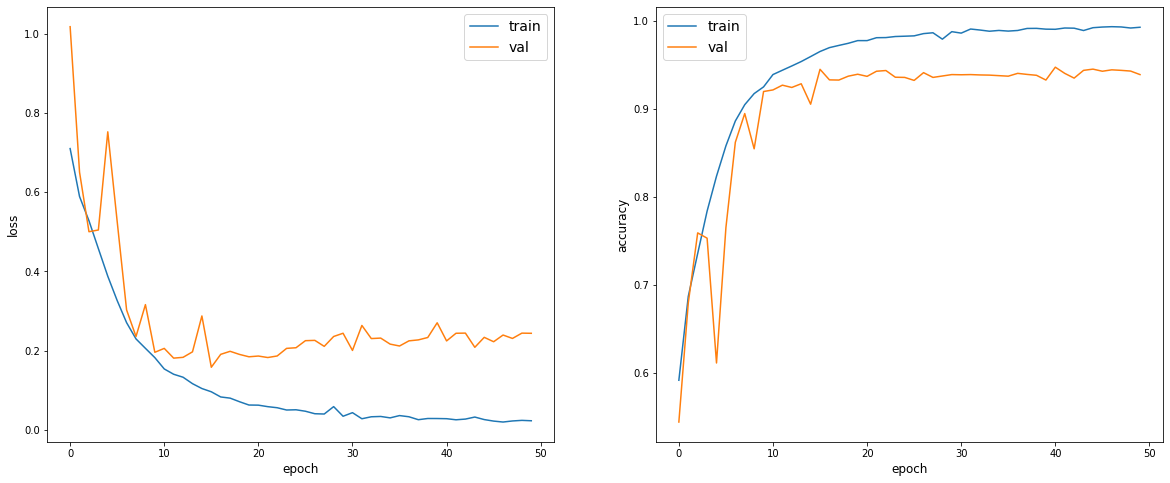

157/157 [==============================] - 2s 14ms/step - loss: 0.2435 - binary_accuracy: 0.9388
Test loss and acc for batch 32: [0.2435448812414517, 0.9387510008006406]
Epoch 1/50
157/157 [==============================] - 29s 154ms/step - loss: 0.7596 - binary_accuracy: 0.5812 - val_loss: 0.7720 - val_binary_accuracy: 0.5030
Epoch 2/50
157/157 [==============================] - 24s 152ms/step - loss: 0.6272 - binary_accuracy: 0.6433 - val_loss: 0.7231 - val_binary_accuracy: 0.5332
Epoch 3/50
157/157 [==============================] - 24s 151ms/step - loss: 0.5718 - binary_accuracy: 0.7017 - val_loss: 0.7779 - val_binary_accuracy: 0.5510
Epoch 4/50
157/157 [==============================] - 24s 151ms/step - loss: 0.5101 - binary_accuracy: 0.7490 - val_loss: 0.7802 - val_binary_accuracy: 0.6159
Epoch 5/50
157/157 [==============================] - 24s 152ms/step - loss: 0.4387 - binary_accuracy: 0.7950 - val_loss: 0.6396 - val_binary_accuracy: 0.7038
Epoch 6/50
157/157 [===============

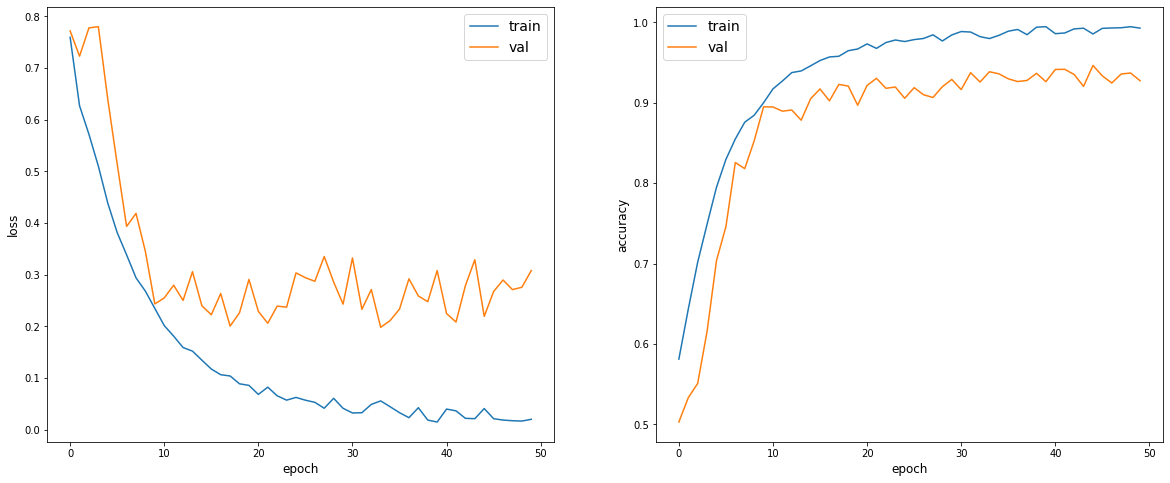

157/157 [==============================] - 2s 14ms/step - loss: 0.3081 - binary_accuracy: 0.9273
Test loss and acc for batch 128: [0.30809139064921387, 0.927341873498799]
Epoch 1/50
79/79 [==============================] - 29s 295ms/step - loss: 0.8041 - binary_accuracy: 0.5569 - val_loss: 0.7682 - val_binary_accuracy: 0.5030
Epoch 2/50
79/79 [==============================] - 23s 287ms/step - loss: 0.6520 - binary_accuracy: 0.6245 - val_loss: 0.6987 - val_binary_accuracy: 0.5088
Epoch 3/50
79/79 [==============================] - 23s 287ms/step - loss: 0.5940 - binary_accuracy: 0.6796 - val_loss: 0.9778 - val_binary_accuracy: 0.5020
Epoch 4/50
79/79 [==============================] - 23s 287ms/step - loss: 0.5676 - binary_accuracy: 0.7038 - val_loss: 0.6992 - val_binary_accuracy: 0.5915
Epoch 5/50
79/79 [==============================] - 23s 287ms/step - loss: 0.5323 - binary_accuracy: 0.7281 - val_loss: 0.7362 - val_binary_accuracy: 0.5663
Epoch 6/50
79/79 [==========================

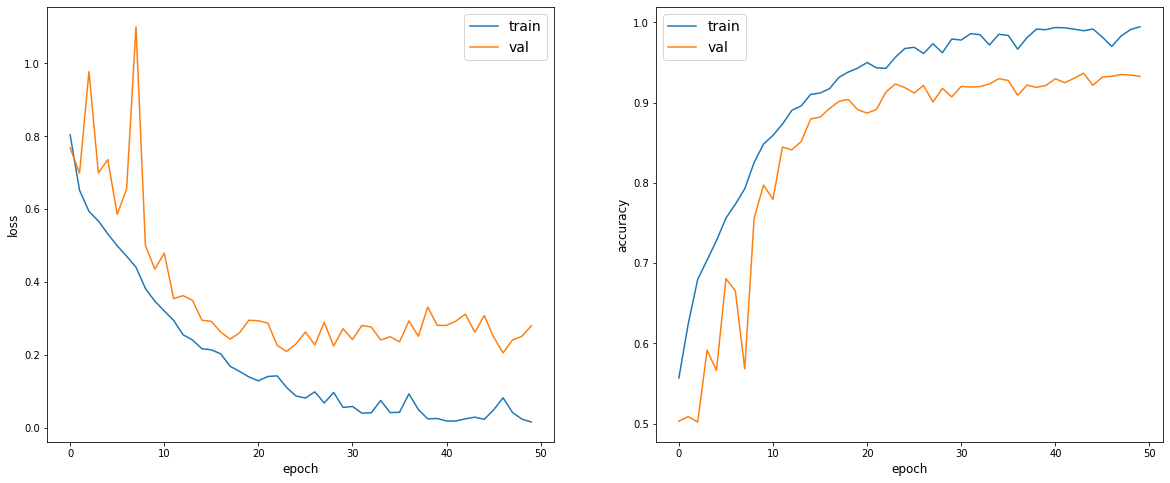

157/157 [==============================] - 2s 14ms/step - loss: 0.2798 - binary_accuracy: 0.9325
Test loss and acc for batch 256: [0.2798330800595412, 0.9325460368294636]


In [14]:
batches = [32, 128, 256]

for batch in batches:
  model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

# compiling the model
  model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

  history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

  performance_plot(history)

  result_op1 = model3.evaluate(X_test, y_test)
  print(f"Test loss and acc for batch {batch}:", result_op1)


Epoch 1/50
313/313 [==============================] - 29s 83ms/step - loss: 0.7770 - binary_accuracy: 0.5800 - val_loss: 0.7030 - val_binary_accuracy: 0.6041
Epoch 2/50
313/313 [==============================] - 25s 81ms/step - loss: 0.7223 - binary_accuracy: 0.6180 - val_loss: 0.6281 - val_binary_accuracy: 0.6669
Epoch 3/50
313/313 [==============================] - 25s 81ms/step - loss: 0.6487 - binary_accuracy: 0.6664 - val_loss: 0.9149 - val_binary_accuracy: 0.5849
Epoch 4/50
313/313 [==============================] - 25s 81ms/step - loss: 0.5844 - binary_accuracy: 0.7103 - val_loss: 0.6388 - val_binary_accuracy: 0.6922
Epoch 5/50
313/313 [==============================] - 25s 81ms/step - loss: 0.5321 - binary_accuracy: 0.7430 - val_loss: 0.6280 - val_binary_accuracy: 0.6789
Epoch 6/50
313/313 [==============================] - 25s 81ms/step - loss: 0.4818 - binary_accuracy: 0.7750 - val_loss: 0.4370 - val_binary_accuracy: 0.8046
Epoch 7/50
313/313 [==============================] 

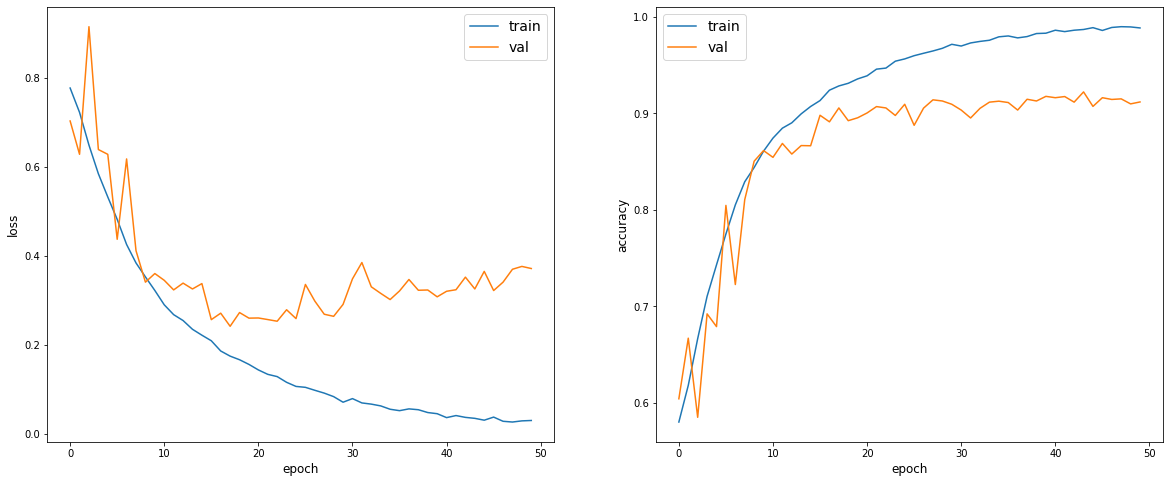

157/157 [==============================] - 2s 13ms/step - loss: 0.3713 - binary_accuracy: 0.9119
test loss, test acc: [0.3713104159952646, 0.911929543634908]


In [18]:
# The best remains model 3 with batch 32, so now we run the model with different optimizers 


# TRAINING MODEL 3 with SGD

model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compiling the model
model3.compile(optimizer = op_2, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = 32, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_op2 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_op2)

Epoch 1/50
313/313 [==============================] - 30s 84ms/step - loss: 0.9066 - binary_accuracy: 0.5749 - val_loss: 0.6978 - val_binary_accuracy: 0.5234
Epoch 2/50
313/313 [==============================] - 26s 83ms/step - loss: 0.7939 - binary_accuracy: 0.6186 - val_loss: 0.6559 - val_binary_accuracy: 0.6189
Epoch 3/50
313/313 [==============================] - 26s 83ms/step - loss: 0.6966 - binary_accuracy: 0.6694 - val_loss: 0.6578 - val_binary_accuracy: 0.6523
Epoch 4/50
313/313 [==============================] - 26s 83ms/step - loss: 0.6322 - binary_accuracy: 0.7028 - val_loss: 0.7665 - val_binary_accuracy: 0.6585
Epoch 5/50
313/313 [==============================] - 26s 83ms/step - loss: 0.5808 - binary_accuracy: 0.7283 - val_loss: 0.7070 - val_binary_accuracy: 0.6835
Epoch 6/50
313/313 [==============================] - 26s 83ms/step - loss: 0.5336 - binary_accuracy: 0.7573 - val_loss: 0.7497 - val_binary_accuracy: 0.6791
Epoch 7/50
313/313 [==============================] 

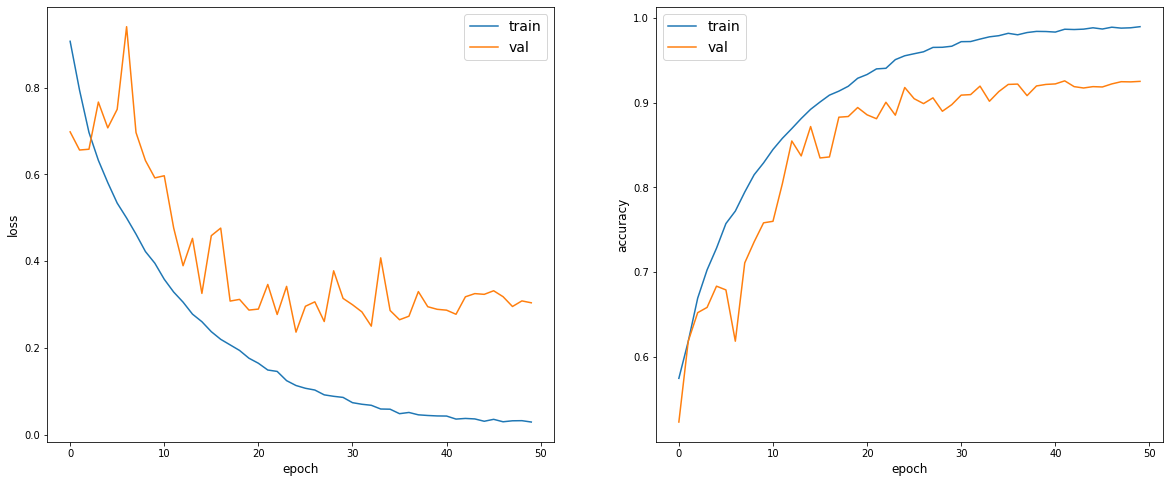

157/157 [==============================] - 2s 13ms/step - loss: 0.3038 - binary_accuracy: 0.9249
test loss, test acc: [0.30384737699117464, 0.9249399519615693]


In [19]:
# TRAINING MODEL 3 with RMSprop

model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compiling the model
model3.compile(optimizer = op_3, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = 32, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_op3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_op3)